# Определение стоимости автомобилей

**Дано:**  
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо построить модель, которая умеет её определять. Есть данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Условия:** 
1. Не ограничиваться градиентным бустингом
2. Для оценки качества моделей применять метрику RMSE. RMSE должно быть меньше 2500.
3. Освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга.
4. Ввести время выполнения ячейки кода
5. В модели градиентного бустинга можно изменять только два-три параметра. 

**План исследования:**
 1. Обзор данных
 2. Предобработка данных
 3. Обучение моделей
 4. Выбор лучшей модели и ее тестирование  
 5. Вывод

## 1. Обзор данных

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

In [2]:
try:
    autos = pd.read_csv('/Users/galina/Desktop/учёба/спринт 11. Численные методы/autos-2.csv') 
except:
    autos = pd.read_csv('/datasets/autos.csv')

In [3]:
display(autos.head(5))
print('-----------------------------------------------------------------')

display(autos.info())
print('-----------------------------------------------------------------')

display(autos.describe())
print('-----------------------------------------------------------------')

print('Кол-во пропусков:')
display(autos.isna().sum())
print('-----------------------------------------------------------------')

print('Кол-во дубликатов -', autos.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  La

None

-----------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


-----------------------------------------------------------------
Кол-во пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

-----------------------------------------------------------------
Кол-во дубликатов - 4


### Выводы по п.1. Обзор данных:
1. Есть признаки, которые никак не влияют на цену - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и	LastSeen. От них надо избавиться
2. В признаках, влияющих на цену, есть пропуски 
3. В целевом признаке и признаке Power есть 0, наверняка есть другие выбросы
4. В RegistrationYear указан минимальный год 1000, наверняка есть другие выбросы
5. Есть дубликаты, от которых также надо избавиться
6. В названиях признаков надо избавиться от верблюжьего стиля
7. В признаках Gearbox и NotRepaired значения можно заменить на 1/0

## 2. Предобработка данных

In [4]:
#перевожу названия в змеиный стиль:
autos.columns = autos.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [5]:
#избавляюсь от дубликатов:
autos.drop_duplicates(inplace=True)  

In [6]:
#избавляюсь от признаков, не влияющих на целевой признак:
autos.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)

### 2.1. Целевой признак price

In [7]:
#смотрю, сколько нулей в целевом признаке:
autos.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64

In [8]:
#удаляю все 0 из целевого признака:
autos = autos.query('price > 0')

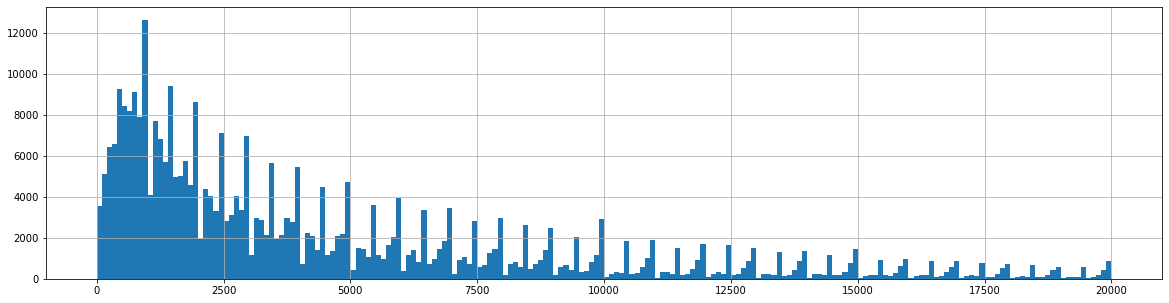

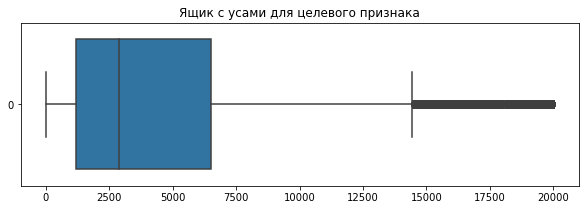

In [9]:
#смотрю гистограмму и ящик с усами для целевого признака: 
autos.price.hist(bins=200, figsize=(20,5))

plt.figure(figsize=(10,3))
sns.boxplot(data=autos.price, orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()

In [10]:
#поскольку на гистограмме и ящике с усами странные данные у нуля и длинный хвост возле 15000, смотрю квантили:
autos.price.quantile([.05, 0.95])

0.05      350.0
0.95    14800.0
Name: price, dtype: float64

In [11]:
#смотрю долю строк, где цена меньше 350 и больше 14800:
1 - autos.query('350 <= price <= 14800').shape[0] / autos.shape[0]

0.09517365021988222

In [12]:
#избавляюсь от 10% строк, где цена меньше 350 и больше 14800:
autos = autos.query('350 <= price <= 14800')

### 2.2. Признак registrationyear	

In [13]:
#смотрю значения в registration_year:
autos.registration_year.value_counts()

2000    20907
2005    20811
1999    20621
2003    19217
2001    19091
        ...  
4800        1
2290        1
1930        1
1001        1
1946        1
Name: registration_year, Length: 130, dtype: int64

In [14]:
annual = autos.pivot_table(index='registration_year', values='brand', aggfunc='count')
annual.columns = ['quantity']
annual

,quantity
registration_year,
1000,18
1001,1
1039,1
1111,1
1234,2
...,...
8500,1
8888,1
9000,2


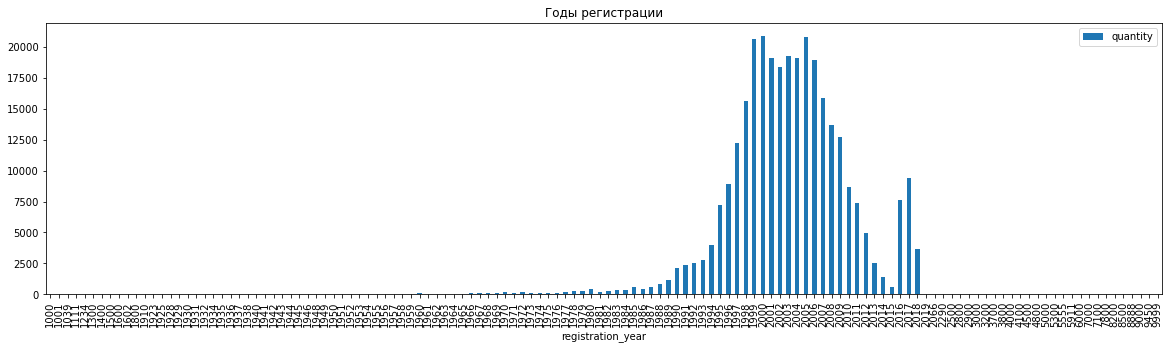

In [15]:
#смотрю график для registrationyear: 
annual.plot.bar(figsize = (20,5))
plt.title('Годы регистрации')
plt.show()

In [16]:
#смотрю самый поздний год выгрузки:
autos_ = pd.read_csv('/Users/galina/Desktop/учёба/спринт 11. Численные методы/autos-2.csv')
autos_.DateCrawled.max()

'2016-04-07 14:36:58'

In [17]:
#вряд ли авто ранее 1975 и позже 2016 (органичение данных) были поставлены на учет и на продажу
#поэтому оставляю в таблице только годы регистрации с 1975 по 2016:
autos = autos.query('1975 <= registration_year <= 2016')

### 2.3. Признак power

In [18]:
#смотрю значения в power:
autos.power.value_counts()

0       26795
75      20640
60      13045
150     13008
101     12106
        ...  
2789        1
2461        1
6006        1
6018        1
1548        1
Name: power, Length: 627, dtype: int64

<AxesSubplot:>

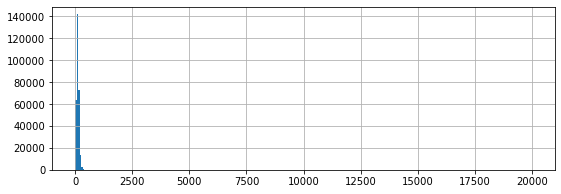

In [19]:
#смотрю гистограмму power:
autos.power.hist(bins=300, figsize=(9,3))

In [20]:
autos.power.describe()

count    296131.000000
mean        111.028275
std         184.505329
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

In [21]:
#поскольку самое мощное по состоянию на 2022 год легковое авто имеет 1600лс,
#а самое слабое из представленных брендов авто - Citroen 2CV - имеет 9лс,  
#то выкину из таблицы всё, что выше и ниже этих границ:
autos = autos.query('9 <= power <= 1600')

### 2.4. Признак kilometer

In [22]:
#смотрю значения в kilometer:
autos.kilometer.value_counts()

150000    183628
125000     29148
100000     11366
90000       9039
80000       7752
70000       6539
60000       5584
50000       4453
40000       3436
30000       2906
20000       2331
5000        2250
10000        580
Name: kilometer, dtype: int64

В признаке kilometer выбросов нет и аномалий нет

### 2.5. Признак brand

In [23]:
autos.brand.value_counts()

volkswagen        58354
opel              29855
bmw               28889
mercedes_benz     24458
audi              22560
ford              18500
renault           12928
peugeot            8945
fiat               7018
seat               5413
skoda              4583
smart              4449
mazda              4446
citroen            4007
toyota             3855
nissan             3602
hyundai            2887
volvo              2564
mini               2491
mitsubishi         2286
honda              2270
kia                1912
suzuki             1848
alfa_romeo         1846
chevrolet          1347
sonstige_autos     1225
chrysler           1093
dacia               785
subaru              571
daihatsu            557
jeep                494
saab                444
porsche             390
jaguar              372
daewoo              366
land_rover          362
lancia              340
rover               327
trabant             222
lada                151
Name: brand, dtype: int64

В признаке brand неявных дубликатов нет

### 2.6. Признак gearbox

In [24]:
#заменяю NaN на 'manual':
autos.fillna({'gearbox':'manual'}, inplace=True)

In [25]:
#заменяю в gearbox значение manual на 1, auto - на 0:
autos.loc[(autos.gearbox == 'manual'), 'gearbox'] = 1   
autos.loc[(autos.gearbox == 'auto'), 'gearbox'] = 0

In [26]:
autos.gearbox = autos.gearbox.astype('int')

### 2.7. Признак notrepaired

In [27]:
#заменяю NaN на 'yes', так как обычно любая подержанная машина была в ремонте:
autos.fillna({'not_repaired':'yes'}, inplace=True)

In [28]:
#заменяю в notrepaired значение yes на 1, no - на 0:
autos.loc[(autos.not_repaired == 'yes'), 'not_repaired'] = 1
autos.loc[(autos.not_repaired == 'no'), 'not_repaired'] = 0

In [29]:
autos.not_repaired = autos.not_repaired.astype('int')

### 2.8. Признак model

In [30]:
#заменяю NaN на 'unknown':
autos.fillna({'model':'unknown'}, inplace=True)
autos.model.value_counts()

golf                  22613
other                 17963
3er                   16108
polo                   9730
unknown                9544
                      ...  
serie_2                   2
range_rover_evoque        2
gl                        2
serie_3                   1
rangerover                1
Name: model, Length: 250, dtype: int64

### 2.9. Признак vehicletype

In [31]:
#заменяю пропуски на unknown:
autos.fillna({'vehicle_type':'unknown'}, inplace=True)
autos.vehicle_type.value_counts()

sedan          76356
small          64638
wagon          54746
bus            24453
convertible    16423
coupe          12311
unknown         9206
suv             8687
other           2192
Name: vehicle_type, dtype: int64

### 2.10. Признак fueltype

In [32]:
autos.fillna({'fuel_type':'unknown'}, inplace=True)
autos.fuel_type.value_counts()

petrol      171651
gasoline     78636
unknown      13456
lpg           4527
cng            467
hybrid         154
other           66
electric        55
Name: fuel_type, dtype: int64

In [33]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269012 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              269012 non-null  int64 
 1   vehicle_type       269012 non-null  object
 2   registration_year  269012 non-null  int64 
 3   gearbox            269012 non-null  int64 
 4   power              269012 non-null  int64 
 5   model              269012 non-null  object
 6   kilometer          269012 non-null  int64 
 7   fuel_type          269012 non-null  object
 8   brand              269012 non-null  object
 9   not_repaired       269012 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 22.6+ MB


In [34]:
autos.corr()['price']

price                1.000000
registration_year    0.530652
gearbox             -0.212265
power                0.406937
kilometer           -0.338210
not_repaired        -0.233246
Name: price, dtype: float64

### Выводы по п.2. Обработка данных:
1. Избавилась от:
- признаков, которые никак не влияют на целевой признак
- верблюжьего стиля
- дубликатов
- выбросов в целевом признаке и признаках

2. Заполнила пропуски в:
- gearbox значением 'manual', и заменила значения на 1/0
- notrepaired значением 'yes', и заменила значения на 1/0
- model, vehicletype, fueltype значением 'unknown'

3. В целом цена логично зависит:
- прямо пропорционально от года регистрации, мощности
- обратно пропорционально от пробега, ремонта, типа коробки

В результате обработки данных датафрейм сократился на 21%, однако данных (278 837 строк) достаточно для обучения моделей

## 3. Обучение моделей

In [35]:
#выделяю признаки и целевой признак:
features_orig = autos.drop('price', axis=1)
target = autos.price

In [36]:
#разделяю на выборки:
features_train, features_test, target_train, target_test = train_test_split(features_orig,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [37]:
#кодирую признаки через OHE:
features_ohe = pd.get_dummies(features_orig, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=.25,
                                                                                            random_state=12345)

In [38]:
#кодирую признаки через OE:
encoder = OrdinalEncoder()

features_train_oe = features_train[['vehicle_type','fuel_type','brand','model']]
features_train_oe = pd.DataFrame(encoder.fit_transform(features_train),
                                 columns=features_train.columns,
                                 index=features_train.index)

features_test_oe = features_test[['vehicle_type','fuel_type','brand','model']]
features_test_oe = pd.DataFrame(encoder.fit_transform(features_test),
                                columns=features_test.columns,
                                index=features_test.index)

target_train_oe = target_train.copy()

target_test_oe = target_test.copy()

In [39]:
#смотрю размеры выборок:
for i in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(i.shape)    
    
print()

for i in [features_train_oe, features_test_oe, target_train_oe, target_test_oe]:
    print(i.shape)

print()
    
for i in [features_train, features_test, target_train, target_test]:
    print(i.shape)

(201759, 308)
(67253, 308)
(201759,)
(67253,)

(201759, 9)
(67253, 9)
(201759,)
(67253,)

(201759, 9)
(67253, 9)
(201759,)
(67253,)


### 3.1. Модель LinearRegression

#### 3.1.1. На выборках c OneHotEncoder 

In [40]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 7.52 s, sys: 2.13 s, total: 9.65 s
Wall time: 2.67 s


LinearRegression()

In [41]:
%%time

target_predict = model_lr.predict(features_train_ohe)

CPU times: user 870 ms, sys: 661 ms, total: 1.53 s
Wall time: 442 ms


In [42]:
rmse_lr_ohe = mean_squared_error(target_train_ohe, target_predict) ** .5
rmse_lr_ohe

2072.533217181473

#### 3.1.2. На выборках c OrdinalEncoder

In [43]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_oe, target_train_oe)

CPU times: user 174 ms, sys: 87.9 ms, total: 262 ms
Wall time: 47.1 ms


LinearRegression()

In [44]:
%%time

target_predict = model_lr.predict(features_train_oe)

CPU times: user 7.15 ms, sys: 5.68 ms, total: 12.8 ms
Wall time: 3.7 ms


In [45]:
rmse_lr_oe = mean_squared_error(target_train_oe, target_predict) ** .5
rmse_lr_oe

2359.4990513276075

#### 3.1.3. C использованием кроссвалидации

In [46]:
%%time

model_lr = LinearRegression()

#mse доступна только как neg_mean_squared_error, которая возвращает массив отрицательных значений
#поэтому на -1 умножаю:
cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_ohe,
                               target_train_ohe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

CPU times: user 34.6 s, sys: 9.62 s, total: 44.3 s
Wall time: 9.58 s


4316599.289912783

In [47]:
%%time

model_lr = LinearRegression()

cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train_oe,
                               target_train_oe,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

CPU times: user 647 ms, sys: 256 ms, total: 903 ms
Wall time: 159 ms


5567904.076855193

### 3.2. Модель CatBoostRegressor

#### 3.2.1. На выборках c OneHotEncoder 

In [48]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 6min 24s, sys: 1min 8s, total: 7min 33s
Wall time: 1min 59s


1305.3142292413966

In [49]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) #подставила лучшие параметры
model_cbr.fit(features_train_ohe, target_train_ohe)

CPU times: user 29.6 s, sys: 4.93 s, total: 34.6 s
Wall time: 8.45 s


In [50]:
%%time

target_predict = model_cbr.predict(features_test_ohe)

CPU times: user 153 ms, sys: 66.5 ms, total: 220 ms
Wall time: 87.1 ms


In [51]:
rmse_cbr_ohe = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_ohe

1301.7942819066543

#### 3.2.2. На выборках c OrdinalEncoder

In [52]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_oe, target_train_oe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_oe = (max(mts) * -1) ** .5
gscv_rsme_cbr_oe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 6min 36s, sys: 1min 10s, total: 7min 46s
Wall time: 1min 48s


1316.6633282151856

In [53]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) 
model_cbr.fit(features_train_oe, target_train_oe)

CPU times: user 31.6 s, sys: 5.15 s, total: 36.7 s
Wall time: 8.46 s


In [54]:
%%time

target_predict = model_cbr.predict(features_test_oe)

CPU times: user 111 ms, sys: 26.4 ms, total: 137 ms
Wall time: 94.6 ms


In [55]:
rmse_cbr_oe = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr_oe

1425.6630298611178

#### 3.2.3. На выборках без кодировки

In [56]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, iterations=200, random_state=12345, verbose=False, 
                              cat_features=['vehicle_type','fuel_type','brand','model']) 

model_cbr.fit(features_train, target_train)

CPU times: user 34.1 s, sys: 1.98 s, total: 36.1 s
Wall time: 7.67 s


In [57]:
%%time

target_predict = model_cbr.predict(features_test)

CPU times: user 138 ms, sys: 17.2 ms, total: 155 ms
Wall time: 88.3 ms


In [58]:
rmse_cbr = mean_squared_error(target_test, target_predict) ** .5
rmse_cbr

1348.3124503562653

### 3.3. Модель LightGBMRegressor

#### 3.3.1. На выборках c OneHotEncoder 

In [59]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train_ohe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 8min 10s, sys: 1min 32s, total: 9min 43s
Wall time: 2min 4s


1304.6188702139004

In [60]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 9.32 s, sys: 1.48 s, total: 10.8 s
Wall time: 2.21 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [61]:
%%time

target_predict = model_lgbmr.predict(features_test_ohe)

CPU times: user 2.39 s, sys: 338 ms, total: 2.73 s
Wall time: 392 ms


In [62]:
rsme_lgbmr_ohe = mean_squared_error(target_test, target_predict) ** .5
rsme_lgbmr_ohe

1291.8139091230903

#### 3.3.2. На выборках c OrdinalEncoder

In [63]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train_oe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

CPU times: user 4min 53s, sys: 40 s, total: 5min 33s
Wall time: 50.6 s


1310.5821401944902

In [64]:
%%time

model = LGBMRegressor(learning_rate=.3, num_leaves=100, random_state=12345)
model.fit(features_train_oe, target_train_oe)

CPU times: user 5.04 s, sys: 815 ms, total: 5.85 s
Wall time: 947 ms


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=12345)

In [65]:
%%time

target_predict = model.predict(features_test_oe)

CPU times: user 761 ms, sys: 27.3 ms, total: 788 ms
Wall time: 129 ms


In [66]:
rsme_lgbmr_oe = mean_squared_error(target_test, target_predict) ** .5
rsme_lgbmr_oe

1395.3927445191594

### Выводы по п.3. Обучение моделей:
1. Обучила 3 модели - линейную регрессию, CatBoostRegressor и LGBMRegressor - со сменой гиперпараметров и на разных выборках - изначальные, с обычной кодировкой и OHE.
2. Часть моделей дали RMSE > 2500, поэтому финальный вывод буду делать только на моделях, которые дали RMSE < 2500

## 4. Выбор лучшей модели и ее тестирование

In [77]:
#создаю сводную таблицу по показателям RMSE < 2500, время обучения модели и время предсказания модели:
index = ['Линейная регрессия с OHE',
         'Линейная регрессия с OE',
         'CatBoostRegressor с OHE',
         'CatBoostRegressor с OE',
         'CatBoostRegressor без кодировки',
         'LGBMRegressor с OHE',
         'LGBMRegressor с OE'
        ]

data = {'RMSE':[rmse_lr_ohe,
                rmse_lr_oe,
                rmse_cbr_ohe,
                rmse_cbr_oe,
                rmse_cbr,
                rsme_lgbmr_ohe,
                rsme_lgbmr_oe],
        
        'Время обучения модели':[9.65,
                                 0.262,
                                 34.6,
                                 36.7,
                                 36.1,
                                 10.8,
                                 5.85],
        
        'Время предсказания модели':[1.33,
                                     0.0128,
                                     0.22,
                                     0.137,
                                     0.155,
                                     2.73,
                                     0.788]
       }

kpi_data = pd.DataFrame(data=data, index=index)

#ввожу столбец Рейтинг с весами:
kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor с OHE,1311.905287,10.800,2.7300,450.512698
CatBoostRegressor с OHE,1301.794282,34.600,0.2200,454.100656
CatBoostRegressor без кодировки,1348.312450,36.100,0.1550,470.390383
LGBMRegressor с OE,1395.392745,5.850,0.7880,476.624073
CatBoostRegressor с OE,1425.663030,36.700,0.1370,496.881640
Линейная регрессия с OHE,2072.533217,9.650,1.3300,708.284694
Линейная регрессия с OE,2359.499051,0.262,0.0128,802.320361


Промежуточный вывод:

Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели, если считать эти параметры одинаково важными для принятия решения, является LGBMRegressor с выборками c OHE.
Аутсайдер рейтинга - модель LinearRegression.

In [78]:
#разделяю данные на обучающую и валидационную выборки в соотношении 60/40:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=.4,
                                                                                            random_state=12345)

#разделяю валидационную выборку на валидационную и тестовую в соотношении 20/20:
features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(features_valid_ohe,
                                                                                            target_valid_ohe,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)

In [79]:
#смотрю размеры получившихся выборок:
for i in [features_train_ohe, features_valid_ohe, features_test_ohe, target_train_ohe, target_valid_ohe, target_test_ohe]:
    print(i.shape)

(161407, 308)
(53803, 308)
(53802, 308)
(161407,)
(53803,)
(53802,)


In [80]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 8.16 s, sys: 1.41 s, total: 9.57 s
Wall time: 2.1 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [81]:
%%time

target_predict_ohe = model_lgbmr.predict(features_valid_ohe)


CPU times: user 1.83 s, sys: 278 ms, total: 2.11 s
Wall time: 400 ms


In [82]:
rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, target_predict_ohe) ** .5
rsme_lgbmr_ohe

1311.9052873934913

In [83]:
%%time

#проверяю качество модели на тестовой выборке:
model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 8.1 s, sys: 1.25 s, total: 9.34 s
Wall time: 1.96 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [84]:
%%time

target_predict_ohe = model_lgbmr.predict(features_test_ohe)

CPU times: user 1.46 s, sys: 45.2 ms, total: 1.5 s
Wall time: 288 ms


In [85]:
final_rsme_lgbmr_ohe = mean_squared_error(target_test_ohe, target_predict_ohe) ** .5
final_rsme_lgbmr_ohe

1302.4869752198506

In [86]:
#добавляю в сравнительную таблицу финальные данные:
kpi_data.loc['Финальные данные на лучшей модели'] = [final_rsme_lgbmr_ohe, 9.34, 1.5, final_rsme_lgbmr_ohe * .34 + 10.1 * .33 + 1.57 * .33]
kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
Финальные данные на лучшей модели,1302.486975,9.340,1.5000,446.696672
LGBMRegressor с OHE,1311.905287,10.800,2.7300,450.512698
CatBoostRegressor с OHE,1301.794282,34.600,0.2200,454.100656
CatBoostRegressor без кодировки,1348.312450,36.100,0.1550,470.390383
LGBMRegressor с OE,1395.392745,5.850,0.7880,476.624073
CatBoostRegressor с OE,1425.663030,36.700,0.1370,496.881640
Линейная регрессия с OHE,2072.533217,9.650,1.3300,708.284694
Линейная регрессия с OE,2359.499051,0.262,0.0128,802.320361


Промежуточный вывод: финальная проверка на лучшей модели - LGBMRegressor с выборками c OHE - дала RMSE 1302, общее место в рейтинге - 1.

## 5. Вывод

В проекте:
- загрузила  данные и провела их предобработку - очистку, заполнение, удаление лишних данных
- сравнила 3 модели с разными гиперпараметрами и выборками
- выбрала лучшую модель по 3 показателям - RMSE, время обучения и время предскзания - и проверила ее на тестовой выборке

Итог - наилучшей моделью стала LGBMRegressor с OHE, которая на финальном тестировании показала RMSE 1302, несмотря на требуемое бОльшее время на обучение и предсказание. То есть если есть время, то лучше пользоваться данной моделью